In [103]:
# All system imports
import logging
import time
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [60]:
# Define our identity based on our hostname, connect to the right PCM.

hostname = !hostname
hostname = hostname[0]
spectroId = int(hostname[-1])
band = hostname[-2]
cam = '%s%d' % (band, spectroId)

print "hostname=%s band=%s spectroId=%s" % (hostname, band, spectroId)

import xcuActor.Controllers.PCM as PCM

pcm = PCM.PCM(host='pcm-%s' % (cam))
pcm.logger.setLevel(logging.INFO)

hostname=bee-b9 band=b spectroId=9


In [72]:
import fpga.ccdFuncs as ccdFuncs
import fpga.nbFuncs as nbFuncs
import testing.ccdProcedures as ccdTests

In [93]:
# Connect to the FPGA

import fpga.ccd as fpgaMod
reload(fpgaMod)

ccd = fpgaMod.CCD(spectroId=spectroId, dewarId=band, adc18bit=1)
ccd.pciReset()

print "FPGA version: 0x%08x" % ccd.peekWord(0)

FPGA version: 0xbeefa070


In [100]:
# connect to the FEE

import fee.feeControl as feeMod
reload(feeMod)

pcm.powerOn('fee')
time.sleep(3.5)

logLevel = 20
fee = feeMod.FeeControl(logLevel=logLevel)

NN00111001


In [95]:
# Fetch serial numbers and temperatures
for thing in 'FEE', 'ADC', 'PA0', 'CCD0', 'CCD1':
    print "serial %-5s: %s" % (thing, fee.doGet('serial',  thing))
        
print
for probe in 'FEE', 'PA', 'ccd0', 'ccd1':
    print "temp   %-5s: %s" % (probe, fee.sendCommandStr('rt,%s' % (probe)))


serial FEE  : 3060351
serial ADC  : 3063057
serial PA0  : 188
serial CCD0 : dummy_00
serial CCD1 : dummy_01

temp   FEE  : 289.91
temp   PA   : 294.54
temp   ccd0 : 273.69
temp   ccd1 : 273.66


In [104]:
feeMod.fee.statusAsCards()

get all enable: 0.00s
get all temps: 0.96s
get all bias: 0.63s
get all voltage: 0.23s
get all offset: 0.53s
get all preset: 0.00s


[('serial.FEE', '3060351', ''),
 ('serial.ADC', '3063057', ''),
 ('serial.PA0', '188', ''),
 ('serial.CCD0', 'dummy_00', ''),
 ('serial.CCD1', 'dummy_01', ''),
 ('revision.FEE', 'PFS BEE Rev 20151221-02, copyright JHU', ''),
 ('temps.CCD0', '273.64', ''),
 ('temps.CCD1', '273.56', ''),
 ('temps.FEE', '295.50', ''),
 ('temps.PA', '294.48', ''),
 ('bias.ch0.P_on', 5.9900000000000002, ''),
 ('bias.ch0.P_off', 5.9900000000000002, ''),
 ('bias.ch0.DG_on', 5.9900000000000002, ''),
 ('bias.ch0.DG_off', 5.9900000000000002, ''),
 ('bias.ch0.S_on', 5.9900000000000002, ''),
 ('bias.ch0.S_off', 5.9900000000000002, ''),
 ('bias.ch0.SW_on', 5.9800000000000004, ''),
 ('bias.ch0.SW_off', 6.04, ''),
 ('bias.ch0.RG_on', 6.0, ''),
 ('bias.ch0.RG_off', 6.0, ''),
 ('bias.ch0.OG', 5.9900000000000002, ''),
 ('bias.ch0.RD', -11.99, ''),
 ('bias.ch0.OD', -4.9900000000000002, ''),
 ('bias.ch0.BB', 29.390000000000001, ''),
 ('bias.ch1.P_on', 5.9900000000000002, ''),
 ('bias.ch1.P_off', 5.9900000000000002, ''),
 

In [96]:
chans = 'ch0', 'ch1'
modes = 'erase', 'expose', 'read', 'wipe', 'idle'

for mode in modes:
    fee.setMode(mode)
    time.sleep(1)
    
    for chan in chans:
        v = fee.sendCommandStr('rb,all,%s' % (chan))
        readAll = np.array([float(b) for b in v.split(',')])
        v = fee.sendCommandStr('gb,all,%s' % (chan))
        getAll = np.array([float(b) for b in v.split(',')])
        
        offby = np.fabs(getAll-readAll)/getAll
                        
        print("%07s %s get : %s" % (mode, chan, ' '.join(["%6.2f" % (f) for f in getAll])))
        print("%07s %s read: %s" % (mode, chan, ' '.join(["%6.2f" % (f) for f in readAll])))
        print("%16s: %s" % (('BAD' if np.any(offby > 0.01) else 'OK'), 
                            ' '.join(["%6.2f" % (f) for f in offby])))
        print


  erase ch0 get :   6.00   6.00   6.00   6.00   6.00   6.00   6.00   6.00   6.00   6.00   6.00 -12.00  -5.00   0.20
  erase ch0 read:   5.99   5.99   5.99   5.99   5.99   5.99   5.98   6.04   6.00   6.00   5.99 -11.99  -4.99   0.00
             BAD:   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.01   0.00   0.00   0.00  -0.00  -0.00   1.00

  erase ch1 get :   6.00   6.00   6.00   6.00   6.00   6.00   6.00   6.00   6.00   6.00   6.00 -12.00  -5.00   0.20
  erase ch1 read:   5.99   5.99   5.99   5.99   5.98   5.98   5.98   6.04   5.99   5.99   5.99 -11.99  -4.99   0.00
             BAD:   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.01   0.00   0.00   0.00  -0.00  -0.00   1.00

 expose ch0 get :  -5.00   3.00   5.00   5.00  -6.00   3.00  -6.00   5.00  -7.50   2.00  -4.50  -5.00  -5.00  45.00
 expose ch0 read:  -5.03   3.01   4.99   4.99  -6.04   3.01  -6.04   5.03  -7.57   2.01  -4.54  -4.99  -4.99  44.32
             BAD:  -0.01   0.00   0.00   0.00  -0.01   0.00  -0.01   0

In [70]:
# Load the clock tables. pfsClocks is used for each readout.
import clocks.read
import clocks.wipe
import clocks
reload(clocks.read)
reload(clocks.wipe)
reload(clocks)

pfsClocks = clocks.read.readClocks
pre, pix, post = pfsClocks()

Automatic pdb calling has been turned OFF
reads n=1 file=False
read 1/1
wiping....
wiped 400 400 0.405952 s
get all enable: 0.00s
get all temps: 1.05s
get all bias: 0.64s
get all voltage: 0.23s
get all offset: 0.53s
get all preset: 0.00s
readTime = 2.46711; expected 2.32595
file : /data/pfs/2016-06-20/PFJA00744091.fits
times: 1.10, 5.47, 0.64
file : /data/pfs/2016-06-20/PFJA00744091.fits
times: wipe: 4.48, exposure: 0.00, readout: 7.24, total=11.72
/
statCols: 20 379
means: [63672.656 5067.604 3914.694 2542.628 6133.250 5058.252 3973.775 2591.854]
devs:  [29.368 29.946 29.281 29.026 1.052 0.958 0.865 0.827]
peak:  6133.0 6130 6227 94.0 313.333333333 0.0031914893617
file: /


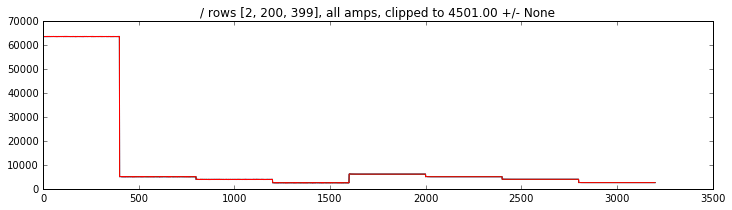









in rawAmpGrid


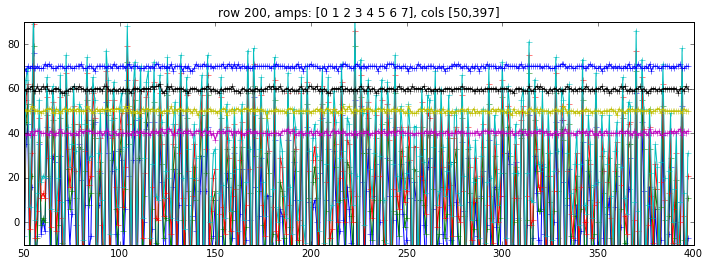

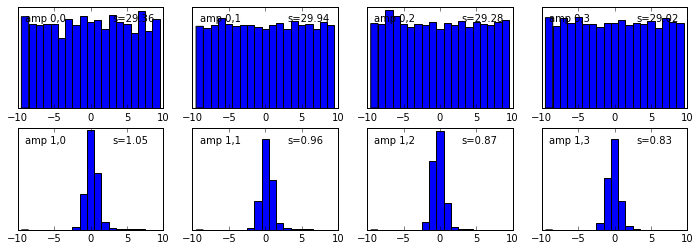

/home/pfs/hostdevel/fullAnaconda/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


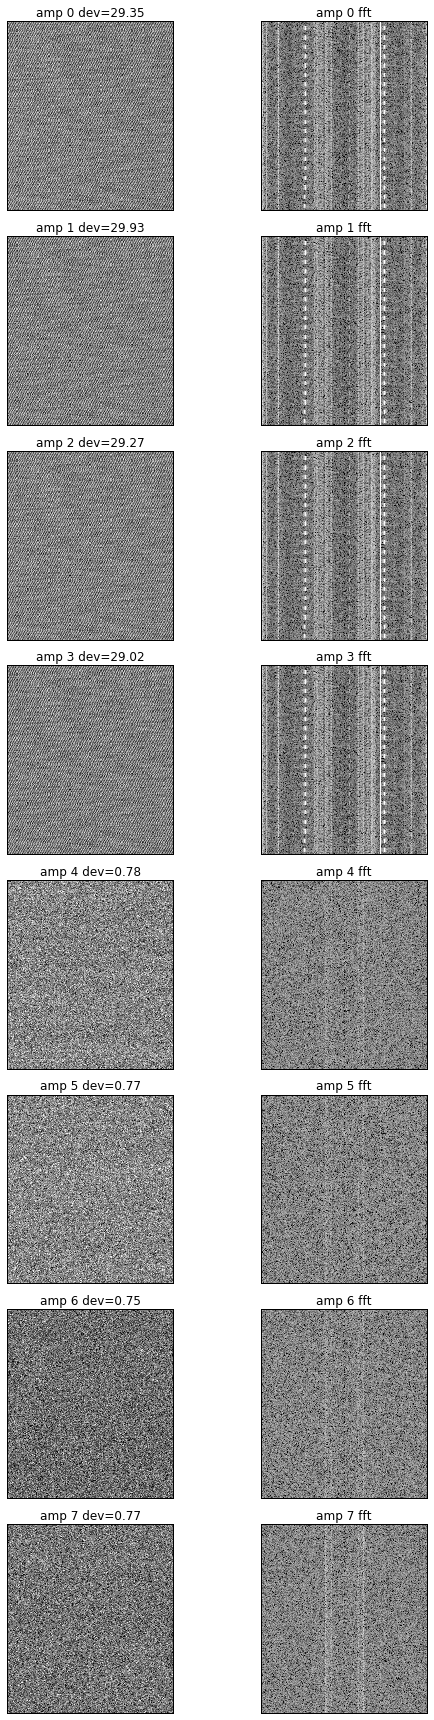

In [105]:
%pdb off
reload(ccdFuncs)
reload(nbFuncs)

# fee.sendCommandStr('sf,slow')

goodAmps = np.arange(8)
badAmps = []

doSave = True
benchTest = True
readTest = False
if benchTest:
    nrows = 400               # How many rows to read out.
    ncols = 400
else:
    nrows = None
    ncols = None
    
#argDict = dict(everyNRows=100, ampList=goodAmps, cols=statCols, ccd=ccd)
argDict = dict(everyNRows=100)

siggenAmp = None
if siggenAmp is None:
    try:
        switch.setCoils(off=range(16))
    except:
        pass
else:
    switch.chooseCoil(siggenAmp)

comment = ''
doFile = False # '/data/pfs/2016-02-26/PFJA00737691.fits'
nreads = 1
print "reads n=%d file=%s" % (nreads, doFile)

if doFile:
    im = fitsio.read(doFile)
    files = [doFile]
    nrows, ncols = im.shape
    ncols /= 8
else:
    for r_i in range(nreads):
        print "read %d/%d" % (r_i+1, nreads)
        if readTest:
            fee.setMode('read')
            time.sleep(1)
            im, files = ccd.readImage(nrows=nrows, ncols=ncols, 
                                      rowFunc=ccdFuncs.rowStats, rowFuncArgs=argDict, 
                                      clockFunc=pfsClocks, doSave=doSave,
                                      comment=comment, addCards=feeCards)
        else:
            im, files = ccdFuncs.fullExposure('bias', ccd, expTime=0.0,
                                              nrows=nrows, ncols=ncols, 
                                              clockFunc=pfsClocks, doSave=doSave,
                                              comment=comment)
        nrows, ncols = im.shape
        ncols /= 8
        
        print files[0]

figWidth = 12

selectRows = slice(0,None)
selectCols = slice(0,None) # None # slice(20,ncols)
pcols = np.arange(50,ncols-2)    # Which cols to plot
prow = nrows/2
prows = [2,prow,nrows-1]       # which rows to plot
statCols = np.arange(20,ncols-20) # Which cols to use for stats
fftAmps = []

if selectRows is not None:
    im = im[selectRows]
if selectCols is not None:
    im = im[:,selectCols]
    
im = im.astype('i4')
if False:
    hi_w = np.where(im > 64000)
    im[hi_w] -= 65535

if siggenAmp is None:
    amp4Mask = ccd.ampidx(4, im)
else:
    amp4Mask = ccd.ampidx(siggenAmp, im)

print "statCols: %d %d" % (statCols[0], statCols[-1])
means,devs = nbFuncs.ampStats(im, ccd=ccd, cols=statCols)
print "means:", nbFuncs.fmtArr(means, format="%0.3f")
print "devs: ", nbFuncs.fmtArr(devs, format="%0.3f")
med4 = np.median(im[prow, amp4Mask])
max4 = np.max(im[prow, amp4Mask])
min4 = np.min(im[prow, amp4Mask])

inject = 0.3
print "peak: ", med4, min4, max4, max4-med4, (max4-med4)/inject, inject/(max4-med4)

# print "shape: %s dtype: %s" % (str(im.shape), im.dtype)
    
if len(files) > 0:
    path = files[0]
    imName = '/'.join(path.split('/')[-2:])
    print "file: %s" % (path)

#focusAmp = 0             # Which amp to focus on
#focusMask = ccd.ampidx(focusAmp, im)[pcols]

# plot one or more rows across the entire image
nbFuncs.plotRows(im, prows, imName=imName, figWidth=figWidth, pixRange=200 if siggenAmp is not None else None)

# plot one row for each the "good" amps
peaks = None # np.arange(1, ncols, 50)
if siggenAmp is not None:
    channel = siggenAmp/4
    amps0 = [siggenAmp]
    amps1 = goodAmps[np.where((goodAmps/4 == channel) & (goodAmps != siggenAmp))]
    amps2 = goodAmps[np.where(goodAmps/4 != channel)]

    nbFuncs.plotAmps(im, amps=amps0, row=prow, cols=pcols, 
                 plotOffset=10, fig=None, figWidth=figWidth, 
                 peaks=peaks, clipPeaks=True)

    nbFuncs.plotAmps(im, amps=amps1, row=prow, cols=pcols, 
                 plotOffset=100, fig=None, figWidth=figWidth, 
                 peaks=peaks, clipPeaks=True)

    nbFuncs.plotAmps(im, amps=amps2, row=prow, cols=pcols, 
                 plotOffset=10, fig=None, figWidth=figWidth)
else:
    nbFuncs.plotAmps(im, amps=goodAmps, row=prow, cols=pcols, 
                     plotOffset=10, fig=None, figWidth=figWidth, 
                     peaks=peaks, clipPeaks=True)

# show a grid of histograms.
hists = nbFuncs.ampHistGrid(im, ccd, cols=statCols, histRange=20, figWidth=figWidth)

# show a grid of raw amp images.
nbFuncs.rawAmpGrid(im, ccd, cols=slice(50,None), figWidth=figWidth, showFfts=True)

fftAmps = [] # np.arange(8) # [1,2,5] # [5,6]
if len(fftAmps) > 0:    
    
    fftFig = plt.figure(figsize=(figWidth, figWidth/4))
    for a in fftAmps:
        fftFig = plt.figure(figsize=(figWidth, figWidth/4))
        fftMask = ccd.ampidx(a, im)[pcols]
        ampSeg = im[prow,fftMask]
        freqs, fft, peak_ii = ccdFuncs.plotTopPeriods(ampSeg, topN=3)


#fig.colorbar(pp)
#plt.tight_layout()